# 📅 Task 2.5: Term Lifecycle Analysis

**Objective**: Analyze how student behaviors (Activity, Conversation) change over the course of the academic term and identify weekly patterns.

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import os

# Set plot style
sns.set_theme(style="whitegrid", palette="viridis", context="talk")
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14

# Data path (Relative path)
# Assuming notebook is in notebooks/02_eda/
DATA_DIR = Path("../../data/raw/dataset")
print(f"Current Working Directory: {os.getcwd()}")
print(f"Data Directory: {DATA_DIR.resolve()}")
print(f"Exists: {DATA_DIR.exists()}")

Current Working Directory: C:\Users\abhay.ahirkar\OneDrive - TRIDIAGONAL.AI PRIVATE LIMITED\learning\StudntLife-Pheno\notebooks\02_eda
Data Directory: C:\Users\abhay.ahirkar\OneDrive - TRIDIAGONAL.AI PRIVATE LIMITED\learning\StudntLife-Pheno\data\raw\dataset
Exists: True


## 2. Aggregating Daily Trends
We will aggregate data daily for all users to observe trends. 
**Metrics**:
- **Activity**: Daily count of 'Walking' (1) and 'Running' (2) inferences.
- **Conversation**: Daily total duration of conversations.

In [2]:
def get_user_list(data_dir):
    # Use glob to find activity files
    search_pattern = str(data_dir / "sensing/activity/activity_*.csv")
    activity_files = glob.glob(search_pattern)
    users = [Path(f).stem.split('_')[1] for f in activity_files]
    return sorted(list(set(users)))

users = get_user_list(DATA_DIR)
print(f"Users found: {len(users)}")

def aggregate_daily_trends(users, data_dir):
    daily_activity = []
    daily_conversation = []

    for uid in users:
        # Activity
        act_path = data_dir / f"sensing/activity/activity_{uid}.csv"
        if act_path.exists():
            try:
                df = pd.read_csv(act_path, index_col=False)
                # Strip whitespace from column names
                df.columns = df.columns.str.strip()
                
                df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')
                df['date'] = df['timestamp'].dt.date
                df['day_of_week'] = df['timestamp'].dt.day_name()
                
                # Count active instances (Walking=1, Running=2)
                # Ensure 'activity inference' column exists
                if 'activity inference' in df.columns:
                    active_counts = df[df['activity inference'].isin([1, 2])].groupby(['date', 'day_of_week']).size().reset_index(name='active_count')
                    active_counts['uid'] = uid
                    daily_activity.append(active_counts)
            except Exception as e:
                print(f"Error processing activity for {uid}: {e}")

        # Conversation
        conv_path = data_dir / f"sensing/conversation/conversation_{uid}.csv"
        if conv_path.exists():
            try:
                df = pd.read_csv(conv_path, index_col=False)
                # Strip whitespace from column names
                df.columns = df.columns.str.strip()
                
                df['start_timestamp'] = pd.to_datetime(df['start_timestamp'], unit='s', errors='coerce')
                df['end_timestamp'] = pd.to_datetime(df['end_timestamp'], unit='s', errors='coerce')
                df['duration'] = (df['end_timestamp'] - df['start_timestamp']).dt.total_seconds()
                df['date'] = df['start_timestamp'].dt.date
                df['day_of_week'] = df['start_timestamp'].dt.day_name()
                
                conv_sums = df.groupby(['date', 'day_of_week'])['duration'].sum().reset_index(name='total_duration')
                conv_sums['uid'] = uid
                daily_conversation.append(conv_sums)
            except Exception as e:
                print(f"Error processing conversation for {uid}: {e}")
    
    act_df = pd.concat(daily_activity, ignore_index=True) if daily_activity else pd.DataFrame()
    conv_df = pd.concat(daily_conversation, ignore_index=True) if daily_conversation else pd.DataFrame()
    
    return act_df, conv_df

print("Aggregating data (this may take a moment)...")
activity_trends, conversation_trends = aggregate_daily_trends(users, DATA_DIR)
print(f"Activity Records: {len(activity_trends)}")
print(f"Conversation Records: {len(conversation_trends)}")

Users found: 49
Aggregating data (this may take a moment)...


Activity Records: 2728
Conversation Records: 2732


## 3. Visualizing Trends Over Term
Plotting the average daily activity and conversation duration across all users over time.

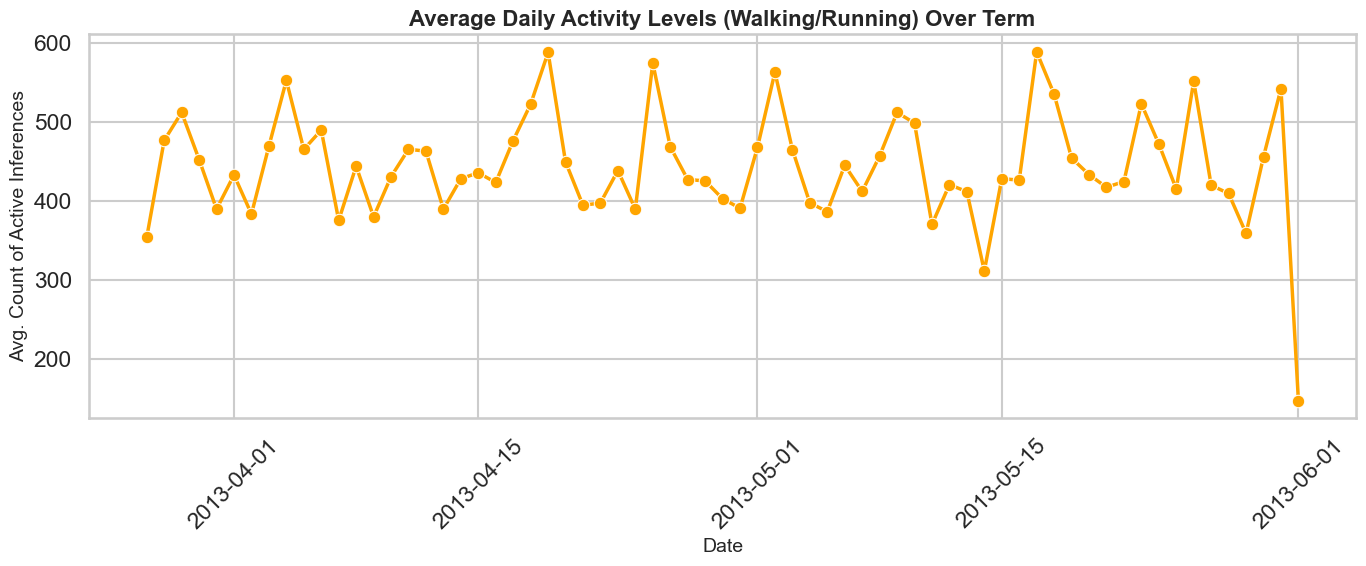

In [3]:
if not activity_trends.empty:
    # Convert date to datetime for plotting
    activity_trends['date'] = pd.to_datetime(activity_trends['date'])
    
    # Calculate mean across users for each day
    daily_avg_activity = activity_trends.groupby('date')['active_count'].mean().reset_index()
    
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=daily_avg_activity, x='date', y='active_count', marker='o', color='orange', linewidth=2.5)
    plt.title("Average Daily Activity Levels (Walking/Running) Over Term", fontweight='bold')
    plt.xlabel("Date")
    plt.ylabel("Avg. Count of Active Inferences")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No activity trend data available.")

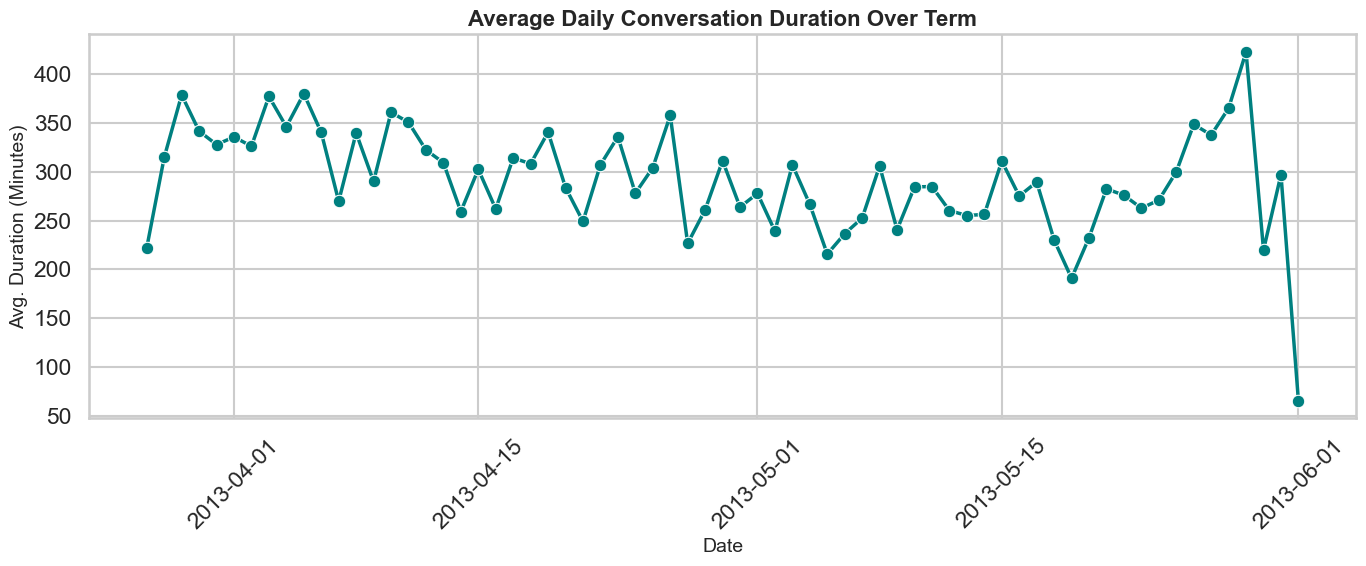

In [4]:
if not conversation_trends.empty:
    conversation_trends['date'] = pd.to_datetime(conversation_trends['date'])
    
    # Calculate mean duration (in minutes)
    conversation_trends['duration_min'] = conversation_trends['total_duration'] / 60
    daily_avg_conv = conversation_trends.groupby('date')['duration_min'].mean().reset_index()
    
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=daily_avg_conv, x='date', y='duration_min', marker='o', color='teal', linewidth=2.5)
    plt.title("Average Daily Conversation Duration Over Term", fontweight='bold')
    plt.xlabel("Date")
    plt.ylabel("Avg. Duration (Minutes)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No conversation trend data available.")

## 4. Day of Week Analysis
Analyzing behavioral patterns based on the day of the week.

C:\Users\abhay.ahirkar\AppData\Local\Temp\ipykernel_24708\2686515246.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=activity_trends, x='day_of_week', y='active_count', order=days_order, palette="Oranges")


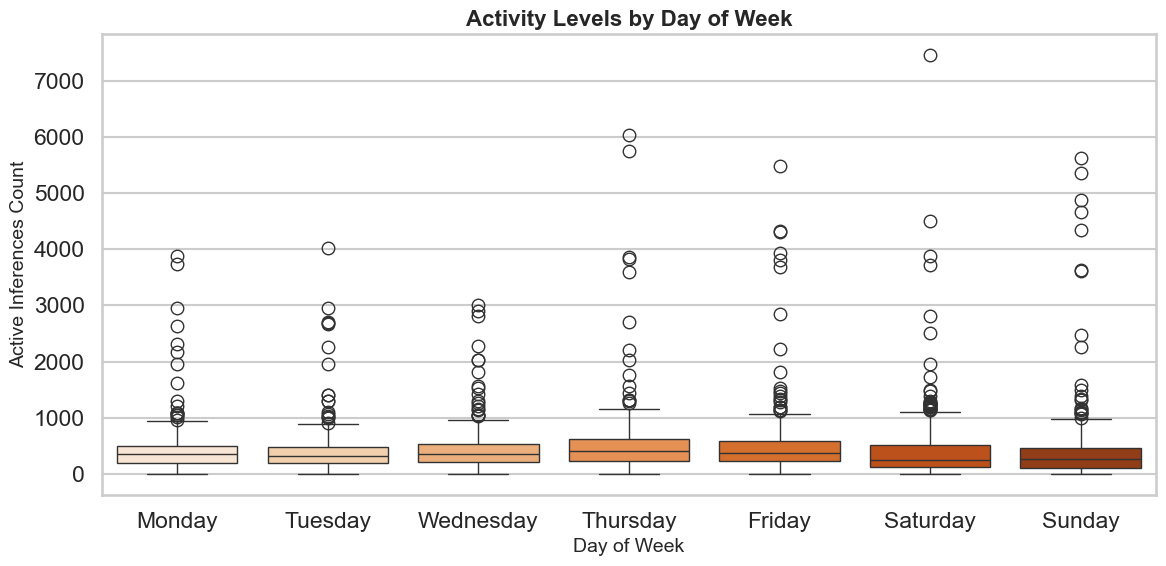

C:\Users\abhay.ahirkar\AppData\Local\Temp\ipykernel_24708\2686515246.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=conversation_trends, x='day_of_week', y='duration_min', order=days_order, palette="Set2")


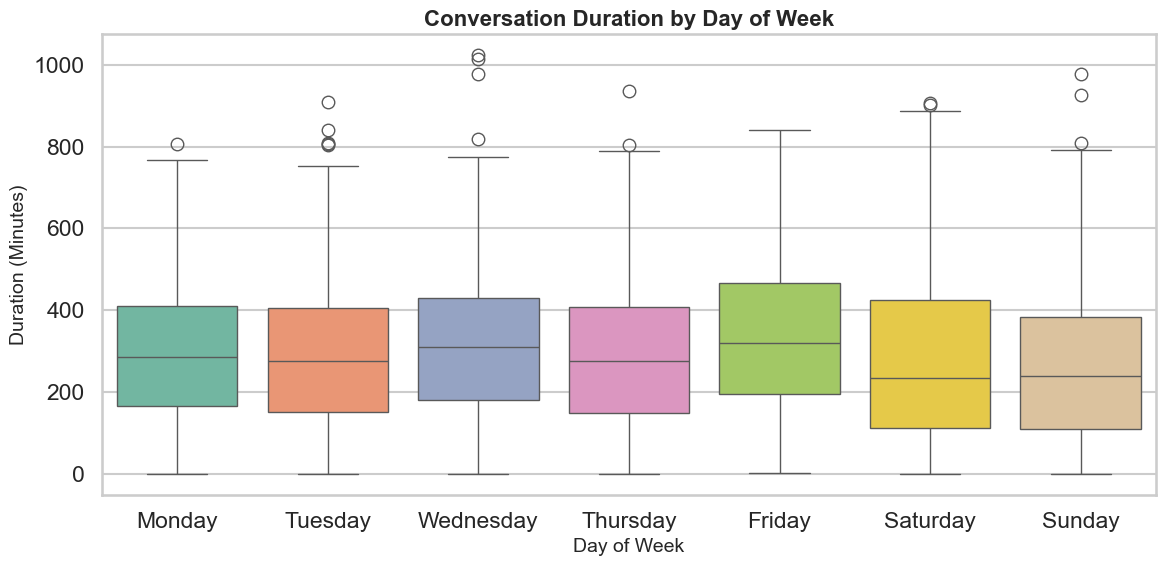

In [5]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

if not activity_trends.empty:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=activity_trends, x='day_of_week', y='active_count', order=days_order, palette="Oranges")
    plt.title("Activity Levels by Day of Week", fontweight='bold')
    plt.xlabel("Day of Week")
    plt.ylabel("Active Inferences Count")
    plt.tight_layout()
    plt.show()

if not conversation_trends.empty:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=conversation_trends, x='day_of_week', y='duration_min', order=days_order, palette="Set2")
    plt.title("Conversation Duration by Day of Week", fontweight='bold')
    plt.xlabel("Day of Week")
    plt.ylabel("Duration (Minutes)")
    plt.tight_layout()
    plt.show()